In [1]:
# import numpy as np
# from curvesim.network import coingecko

# USDC = "0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48"
# USDT = "0xdac17f958d2ee523a2206206994597c13d831ec7"

# coins = np.array([USDC, USDT])
# vs_ccy = "USD"
# days = 60
# chain = "mainnet"
# prices = coingecko.pool_prices(coins, vs_ccy, days, chain)
# prices

# Price Exploration

1. Start with getting historical data from USDC depeg following SVB collapse.
2. Then generate different kinds of simulated data and compare.

In [48]:
from src.sim.prices import get_prices_df
from curvesim.network.coingecko import coin_ids_from_addresses_sync
from datetime import datetime
import matplotlib.pyplot as plt

In [59]:
df

,usd-coin,tether,timestamp
datetime,,,
2023-03-05 05:00:00,1.000798,1.000752,1678010400
2023-03-05 06:00:00,1.000981,1.001072,1678014000
2023-03-05 07:00:00,1.000733,1.001146,1678017600
2023-03-05 08:00:00,1.000848,1.000974,1678021200
2023-03-05 09:00:00,1.000571,1.001113,1678024800
...,...,...,...
2023-03-14 23:00:00,1.000433,1.004424,1678849200
2023-03-15 00:00:00,0.999323,1.003882,1678852800
2023-03-15 01:00:00,1.001611,1.003984,1678856400


In [45]:
USDC = "0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48"
USDT = "0xdac17f958d2ee523a2206206994597c13d831ec7"

coins = [USDC, USDT]
coins = coin_ids_from_addresses_sync(coins, "mainnet")

start = datetime(2023, 3, 5).timestamp()
end = datetime(2023, 3, 15).timestamp()

df = get_prices_df(coins, start, end)

[DEBUG][22:33:57][urllib3.connectionpool]-93948: Starting new HTTPS connection (1): api.coingecko.com:443
[DEBUG][22:33:57][urllib3.connectionpool]-93948: https://api.coingecko.com:443 "GET /api/v3/coins/usd-coin/market_chart/range?vs_currency=usd&from=1677992400.0&to=1678852800.0 HTTP/1.1" 200 None
[DEBUG][22:33:57][urllib3.connectionpool]-93948: Starting new HTTPS connection (1): api.coingecko.com:443
[DEBUG][22:33:57][urllib3.connectionpool]-93948: https://api.coingecko.com:443 "GET /api/v3/coins/tether/market_chart/range?vs_currency=usd&from=1677992400.0&to=1678852800.0 HTTP/1.1" 200 None


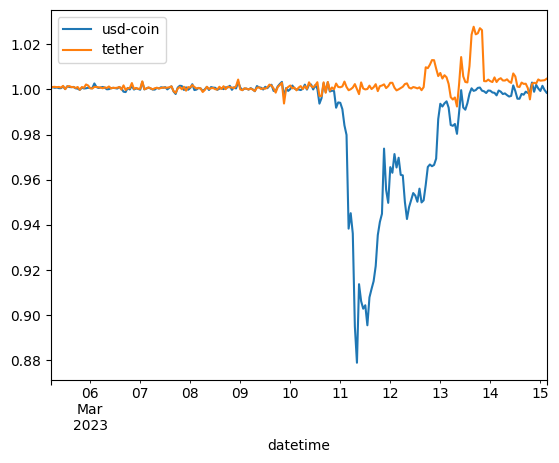

In [50]:
for coin in coins:
    df[coin].plot(label=coin)
plt.legend()

## Simulated

In [39]:
from scipy.optimize import minimize

# Derivation of drift and volatility for simple GBM

prices = df["price"]
returns = prices.pct_change().dropna()
log_returns = np.log(1 + returns)

mu = np.mean(log_returns)  # don't assume to be 0
sigma = np.std(log_returns)

-1.199577432314395e-06 0.0007850043421898245


/var/folders/3r/4cwkccx9163_2pw62tzw8jwh0000gn/T/ipykernel_78668/2445511521.py:22: RuntimeWarning: divide by zero encountered in log
  -np.log(sigma * np.sqrt(2 * np.pi * dt)) -


In [41]:
# Estimate kappa, theta, using MLE for Ornstein-Uhlenbeck
def neg_log_likelihood(params, data):
    mu, sigma, kappa = params
    likelihood = np.sum(
        -np.log(sigma * np.sqrt(2 * np.pi * dt))
        - ((data[1:] - (mu + (data[:-1] - mu) * np.exp(-kappa * dt))) ** 2)
        / (2 * sigma**2 * dt)
    )
    return -likelihood


initial_params = [mu, sigma, 1]
result = minimize(
    neg_log_likelihood,
    initial_params,
    args=(price_data,),
    bounds=[(None, None), (0, None), (0, None)],
)
kappa_estimate = result.x[1]

0.0007850043421898245

# Dump

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def mean_reverting_correlated_gbm(n, corr_matrix, sigmas, kappas, thetas, T=365, dt=1):
    
    # Create covariance matrix from correlation matrix and volatilities
    D = np.diag(sigmas)
    cov_matrix = D.dot(corr_matrix).dot(D)
    
    # Generate uncorrelated Brownian motions
    dW = np.sqrt(dt) * np.random.randn(T, n)
    
    # Apply Cholesky decomposition to get correlated Brownian motions
    L = np.linalg.cholesky(cov_matrix)
    dW_correlated = dW.dot(L.T)
    
    # Initialize asset prices
    S = np.zeros((T, n))
    S[0] = np.array([1,1,1])  # Initial price for each asset
    
    # Generate GBM paths with mean-reversion
    for t in range(1, T):
        mean_reversion = kappas * (thetas - S[t-1]) * dt
        stochastic_term = dW_correlated[t]
        S[t] = S[t-1] + mean_reversion + stochastic_term
        
    return S


# TODO eventually incorporate Jump diffusion using a 
# Poisson point process?

# Initialize parameters
n_assets = 3
n_steps = 365
dt = 1
mu = np.array([0,0,0])  # Drift for each asset
sigma = np.array([0.001, 0.001, 0.001])  # Volatility for each asset
S0 = np.array([1,1,1])  # Initial price for each asset
cor_matrix = np.array([[1.0, 0.6, 0.8], [0.6, 1.0, 0.8], [0.8, 0.6, 1.0]])
thetas = np.ones(1, n_assets)
kappas = 
S = mean_reverting_correlated_gbm(n_assets, cor_matrix, sigma, kappas, thetas, n_steps, dt)
print(S.shape)

# Plot the results
f, ax = plt.subplots(figsize=(12, 6))
for i in range(n_assets):
    ax.plot(S[:, i], label=f'Asset {i+1}')

ax.set_title('Correlated Geometric Brownian Motions')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Asset Price')
ax.set_ylim(0, 1.1*np.max(S))
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Simulated price data
price_data = np.random.randn(1000)  # Replace with actual price data
returns = np.log(price_data[1:] / price_data[:-1])

# Estimate mu (drift)
mu_estimate = np.mean(returns)

# Estimate sigma (volatility)
sigma_estimate = np.std(returns)


# Estimate kappa (mean-reversion rate) using MLE for Ornstein-Uhlenbeck
def neg_log_likelihood(params, data):
    mu, kappa, sigma = params
    dt = 1  # time step
    n = len(data)
    likelihood = np.sum(
        -np.log(sigma * np.sqrt(2 * np.pi * dt))
        - ((data[1:] - (mu + (data[:-1] - mu) * np.exp(-kappa * dt))) ** 2)
        / (2 * sigma**2 * dt)
    )
    return -likelihood


initial_params = [mu_estimate, 1, sigma_estimate]
result = minimize(
    neg_log_likelihood,
    initial_params,
    args=(price_data,),
    bounds=[(None, None), (0, None), (0, None)],
)
kappa_estimate = result.x[1]

In [ ]:
import numpy as np


def correlated_gbm(
    n,
    corr_matrix,
    mus,
    sigmas,
    T=365,
    dt=1,
):
    # Generate uncorrelated Brownian motions
    dW = np.sqrt(dt) * np.random.randn(T, n)

    # Apply Cholesky decomposition to get correlated Brownian motions
    L = np.linalg.cholesky(corr_matrix)
    dW_correlated = dW.dot(L.T)

    # Initialize asset prices
    S = np.zeros((T, n))
    S[0] = np.array([1, 1, 1])  # Initial price for each asset

    # Generate GBM paths
    for t in range(1, T):
        S[t] = S[t - 1] * np.exp(
            (mus - 0.5 * sigmas**2) * dt + sigmas * dW_correlated[t]
        )

    return S


n = 4

# Generate random covariance matrix and ensure
# it is positive semi-definite for Cholesky decomposition.
# Doesn't matter whether we use covariance or correlation but
# covariance is the standard. If we use correlation we need
# to incorporate individual volatilities in GBM equation.
cov = np.random.randn(n, n)
cov = cov.T.dot(cov)  # Ensure positive-definite
assert np.all(np.linalg.eigvals(cov) >= 0), AssertionError(
    "Covariance matrix is not positive semi-definite."
)  # Check positive-definite

# Generate random drifts and variances
cov

In [ ]:
def jump_diffusion_gbm(
    n, corr_matrix, mus, sigmas, lambdas, jump_mus, jump_sigmas, T=365, dt=1
):
    # Create covariance matrix from correlation matrix and volatilities
    D = np.diag(sigmas)
    cov_matrix = D.dot(corr_matrix).dot(D)

    # Generate uncorrelated Brownian motions
    dW = np.sqrt(dt) * np.random.randn(T, n)

    # Apply Cholesky decomposition to get correlated Brownian motions
    L = np.linalg.cholesky(cov_matrix)
    dW_correlated = dW.dot(L.T)

    # Initialize asset prices
    S = np.zeros((T, n))
    S[0] = np.array([1, 1, 1])  # Initial price for each asset

    # Generate Poisson jumps
    dN = np.random.poisson(lambdas * dt, (T, n))

    # Generate GBM paths with jump-diffusion
    for t in range(1, T):
        jump = np.random.normal(jump_mus, jump_sigmas) * dN[t]
        S[t] = (
            S[t - 1]
            * np.exp((mus - 0.5 * sigmas**2) * dt + sigmas * dW_correlated[t])
            * np.exp(jump)
        )

    return S


# Initialize parameters
n_assets = 3
n_steps = 365
dt = 1
mu = np.array([0, 0, 0])  # Drift for each asset
sigma = np.array([0.001, 0.001, 0.001])  # Volatility for each asset
S0 = np.array([1, 1, 1])  # Initial price for each asset
cor_matrix = np.array([[1.0, 0.6, 0.8], [0.6, 1.0, 0.8], [0.8, 0.6, 1.0]])
S = jump_diffusion_gbm(n_assets, cor_matrix, mu, sigma, n_steps, dt)
print(S.shape)

# Plot the results
f, ax = plt.subplots(figsize=(12, 6))
for i in range(n_assets):
    ax.plot(S[:, i], label=f"Asset {i+1}")

ax.set_title("Correlated Geometric Brownian Motions")
ax.set_xlabel("Time Steps")
ax.set_ylabel("Asset Price")
ax.set_ylim(0, 1.1 * np.max(S))
plt.legend()
plt.show()

In [ ]:
import numpy as np


def generate_correlated_ou_process(T, dt, theta, mu, sigma, rho, N=2):
    """
    Generate N correlated Ornstein-Uhlenbeck processes.

    Parameters:
    T     -- Total time
    dt    -- Time step
    theta -- Rate of mean reversion
    mu    -- Long-term mean
    sigma -- Volatility
    rho   -- Correlation coefficient between processes (-1 <= rho <= 1)
    N     -- Number of correlated processes to generate

    Returns:
    X     -- Array of shape (N, timesteps) containing the OU processes
    """
    # Number of time steps
    timesteps = int(T / dt)

    # Initialize processes
    X = np.zeros((N, timesteps))

    # Generate correlated Brownian motions
    dW = np.random.normal(0, np.sqrt(dt), (N, timesteps))
    dW[1:] = rho * dW[0] + np.sqrt(1 - rho**2) * dW[1:]

    # Generate OU processes
    for t in range(1, timesteps):
        X[:, t] = X[:, t - 1] + theta * (mu - X[:, t - 1]) * dt + sigma * dW[:, t]

    return X


# Parameters
T = 10  # Total time
dt = 0.01  # Time step
theta = 0.1  # Rate of mean reversion
mu = 0.0  # Long-term mean
sigma = 0.1  # Volatility
rho = 0.5  # Correlation between processes

# Generate processes
X = generate_correlated_ou_process(T, dt, theta, mu, sigma, rho)

# X[0] and X[1] are now two correlated Ornstein-Uhlenbeck processes